Student Name: Vilohit Keshava Murthy Achar

Student ID: 23077751

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
import torchvision
import torch.nn.functional as tnf
import torch.optim as optim


### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [2]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it
        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?
        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?
        optimizer.zero_grad()               #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy




**model.train()        #<--- what is this function for?**

The model will be trained as a result.

**X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it**

We are examining platform-dependent devices. We will shift X and Y to that device using the code above. X is input, and Y is labels.It's CUDA here
**pred = model(X)                     #<--- what is this for?**

The model will use X as the input, and the pred variable will hold the prediction.

**loss = loss_fn(pred, y)             #<--- what is
this for?**

The projected and actual values' difference value will now be stored in the earlier sentence.


**loss.backward()                     #<--- what is this for?**

It computes the model's parameter gradients with respect to the loss. These gradients show how a little adjustment to any one of the components might potentially increase or reduce loss

**optimizer.step()                    #<--- what is this for?**

The model's parameters are updated at this point using the produced gradients. For the model's parameters, the optimizer selects a particular update rule—like Adam, which we used in this assignment. The optimizer.step() method is used to complete one optimization step. It adjusts the model's parameters based on the computed gradients and the optimization technique used.


**optimizer.zero_grad()               #<--- what is this for?**
This operation resets the gradients to zero at the end of each batch. To prevent the increase of gradients between batches, which happens by default, we may use this method. The calculation of the gradient is performed individually for each batch. Prior to computing the gradients for a new batch, it is imperative to reset the gradients from the prior batch to zero. Otherwise, the combination of the new gradients with the old ones would lead to incorrect updates of the parameters.


### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

In [ ]:
# Your code below
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.2859, 0.3530),transforms.Resize((28,28))])

tr_data = datasets.FashionMNIST(root='/', train=True, download=True, transform=transform)
tt_data = datasets.FashionMNIST(root='/', train=False, download=True, transform=transform)

batch_length = 64
tr_loader = DataLoader(tr_data, batch_size=batch_length, shuffle=True)
tt_loader = DataLoader(tt_data, batch_size=batch_length, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 15101609.85it/s]


Extracting /FashionMNIST/raw/train-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271883.66it/s]


Extracting /FashionMNIST/raw/train-labels-idx1-ubyte.gz to /FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4959179.85it/s]


Extracting /FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4579486.11it/s]

Extracting /FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /FashionMNIST/raw



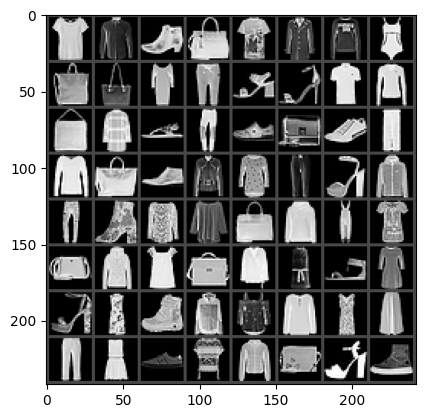

T-shirt/top Shirt Ankle boot Bag T-shirt/top Coat Pullover T-shirt/top Bag Bag Dress Trouser Sandal Sandal T-shirt/top Pullover Bag Coat Sandal Trouser Sneaker Bag Sneaker Trouser Pullover Bag Ankle boot Coat T-shirt/top Trouser Sandal Coat Trouser Ankle boot Shirt Shirt Bag Pullover Trouser T-shirt/top Bag Coat Shirt Bag Shirt Dress Sandal Dress Sandal Dress Ankle boot Coat Shirt Shirt Dress Trouser Trouser Dress Sneaker T-shirt/top Coat Bag Sandal Ankle boot


In [ ]:
data_categories = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]


batch_images, batch_labels = next(iter(tr_loader))

collage = torchvision.utils.make_grid(batch_images)

normalized_collage = (collage * 0.3530) + 0.2859

collage_np = normalized_collage.numpy()
plt.imshow(np.transpose(collage_np, (1, 2, 0)))
plt.show()


print(" ".join(data_categories[label.item()] for label in batch_labels))


---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


In [ ]:
##############################
# Your code below

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
      super(NeuralNetwork, self).__init__()
      self.flatten = nn.Flatten()
      self.fc_one = nn.Linear(28*28, 200)
      self.relu = nn.ReLU()
      self.fc_two = nn.Linear(200, 10)

    def forward(self, x):
      x = self.flatten(x)
      x = self.fc_one(x)
      x = self.relu(x)
      x = self.fc_two(x)
      return x

device = torch.device("cuda")
model = NeuralNetwork().to(device)
summary(model, (1,28*28))


print('=======================================')


testing_prot = torch.randn((64, 1, 28, 28)).to(device)
output_0f_model = model(testing_prot)
probability_test_model = tnf.softmax(output_0f_model, dim=1)

print('Model output shape:', output_0f_model.shape)
print('Model output shape:', probability_test_model.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.61
Estimated Total Size (MB): 0.62
----------------------------------------------------------------
Model output shape: torch.Size([64, 10])
Model output shape: torch.Size([64, 10])


Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

##############################
# Your code below
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(tr_loader, tt_loader, model,loss_fn, optimizer, 20)

print("Training Accuracy : ", train_accuracy)
print("Test Accuracy : ", test_accuracy)
print("Training Loss : ", train_loss)
print("Test Loss : ", test_loss)

Epoch 1:

loss: 2.355978  [   64/60000]
loss: 0.599524  [ 6464/60000]
loss: 0.696659  [12864/60000]
loss: 0.526121  [19264/60000]
loss: 0.449631  [25664/60000]
loss: 0.422379  [32064/60000]
loss: 0.377384  [38464/60000]
loss: 0.380654  [44864/60000]
loss: 0.450969  [51264/60000]
loss: 0.262675  [57664/60000]
Train Error: 
 Accuracy: 86.9%, Avg loss: 0.357837 

Test Error: 
 Accuracy: 85.4%, Avg loss: 0.407709 

Epoch 2:

loss: 0.462170  [   64/60000]
loss: 0.346109  [ 6464/60000]
loss: 0.306794  [12864/60000]
loss: 0.417785  [19264/60000]
loss: 0.197906  [25664/60000]
loss: 0.276414  [32064/60000]
loss: 0.164098  [38464/60000]
loss: 0.265248  [44864/60000]
loss: 0.282696  [51264/60000]
loss: 0.231494  [57664/60000]
Train Error: 
 Accuracy: 88.8%, Avg loss: 0.303242 

Test Error: 
 Accuracy: 86.9%, Avg loss: 0.366833 

Epoch 3:

loss: 0.317121  [   64/60000]
loss: 0.219979  [ 6464/60000]
loss: 0.363588  [12864/60000]
loss: 0.323439  [19264/60000]
loss: 0.204257  [25664/60000]
loss: 0.38

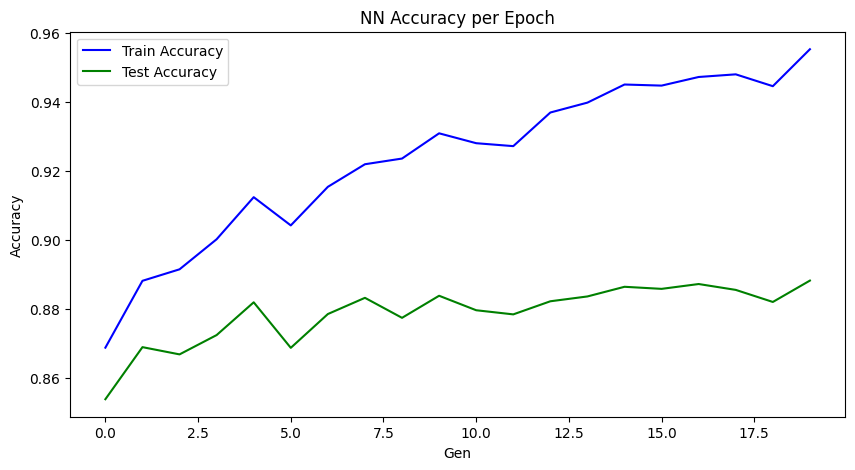

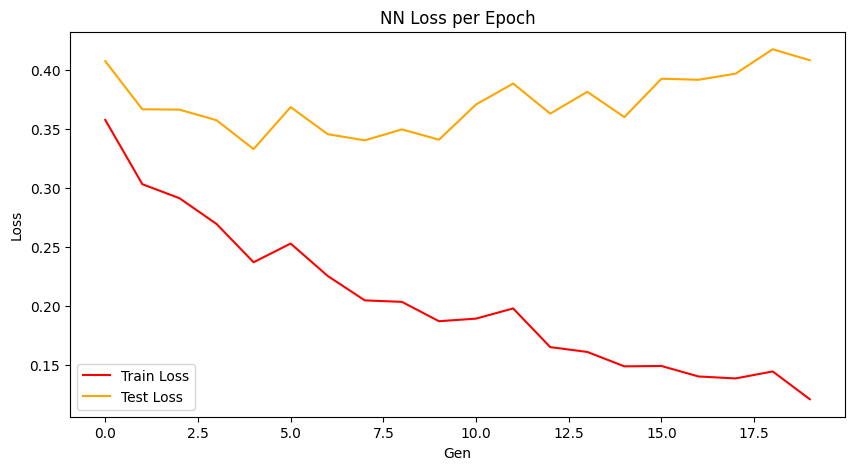

In [ ]:
def plot_accuracy(train_accuracy, test_accuracy):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy, label='Train Accuracy', color='blue')  # Change color if needed
    plt.plot(test_accuracy, label='Test Accuracy', color='green')  # Change color if needed
    plt.title('NN Accuracy per Epoch')
    plt.xlabel('Gen')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss', color='red')  # Change color if needed
    plt.plot(test_loss, label='Test Loss', color='orange')  # Change color if needed
    plt.title('NN Loss per Epoch')
    plt.xlabel('Gen')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_accuracy(train_accuracy, test_accuracy)
plot_loss(train_loss, test_loss)

Explanation:
The training data consists of 60,000 samples, and the batch size used is 64.

Observations of graph:

Accuracy achieved during training:

This displays the performance of the model on the training dataset at various epochs. Accuracy begins with 86.88% and with several iterations it climbs to 95.53%. Through these cycles and adjustments it illustrates how model learns.


Test Accuracy:

This accuracy varies from 85.39 to 88.83%. After a certain number of iterations, the test accuracy does not show any noteworthy improvement beyond the original training accuracy. This might suggest that the model is encountering difficulties in generalizing to new, untested data.


Training Loss:

Training loss varies from 35.78% to 12.06% demonstrating the accuracy of the model. This demonstrates the model is reducing error.


Test Loss: Unfortunately model's test loss begins at 40.77% and declines with iterations it minimises to 34.04% but after that model looks experiencing challenges with predicting new data since it climb again to 40.84%.




---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

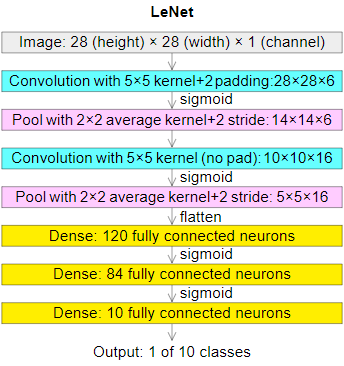

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Convolutional_Neural_Networks(nn.Module):
    def __init__(self, input_array=(1, 28, 28)):
        super(Convolutional_Neural_Networks, self).__init__()

        self.convo_one = nn.Conv2d(input_array[0], 6, kernel_size=5, padding=2)
        self.convo_two = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.sig_one = nn.Sigmoid()
        self.sig_two = nn.Sigmoid()
        self.avg_one = nn.AvgPool2d(kernel_size=2, stride=2)
        self.avg_two = nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()


        self.li_one = nn.Linear(16 * 5 * 5, 280)
        self.li_two = nn.Linear(280, 70)
        self.li_three = nn.Linear(70, 10)
        self.sig_three = nn.Sigmoid()
        self.sig_four = nn.Sigmoid()


    def forward(self, x):
        x = self.avg_one(self.sig_one(self.convo_one(x)))
        x = self.avg_two(self.sig_two(self.convo_two(x)))
        x = self.flatten(x)
        x = self.sig_three(self.li_one(x))
        x = self.sig_four(self.li_two(x))
        x = self.li_three(x)
        return x



# Initialize LeNet model
lenet = Convolutional_Neural_Networks()
print(lenet)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer_l = optim.Adam(lenet.parameters(), lr=1e-3)

Convolutional_Neural_Networks(
  (convo_one): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (convo_two): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (sig_one): Sigmoid()
  (sig_two): Sigmoid()
  (avg_one): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (avg_two): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (li_one): Linear(in_features=400, out_features=280, bias=True)
  (li_two): Linear(in_features=280, out_features=70, bias=True)
  (li_three): Linear(in_features=70, out_features=10, bias=True)
  (sig_three): Sigmoid()
  (sig_four): Sigmoid()
)


In [ ]:
Convolutional_Neural_Networks_train_loss, Convolutional_Neural_Networks_train_accuracy, Convolutional_Neural_Networks_test_loss, Convolutional_Neural_Networks_test_accuracy = train_loop(tr_loader,tt_loader,lenet.to(device),loss_fn,optimizer_l,20)

print("Training Accuracy : ", Convolutional_Neural_Networks_train_accuracy)
print("Test Accuracy : ",Convolutional_Neural_Networks_test_accuracy)
print("Training Loss : ", Convolutional_Neural_Networks_train_loss)
print("Test Loss : ", Convolutional_Neural_Networks_test_loss)

Epoch 1:

loss: 0.247474  [   64/60000]
loss: 0.151829  [ 6464/60000]
loss: 0.204633  [12864/60000]
loss: 0.265902  [19264/60000]
loss: 0.198390  [25664/60000]
loss: 0.284955  [32064/60000]
loss: 0.121836  [38464/60000]
loss: 0.185340  [44864/60000]
loss: 0.246891  [51264/60000]
loss: 0.101623  [57664/60000]
Train Error: 
 Accuracy: 93.9%, Avg loss: 0.167038 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.281410 

Epoch 2:

loss: 0.228682  [   64/60000]
loss: 0.220805  [ 6464/60000]
loss: 0.177300  [12864/60000]
loss: 0.097458  [19264/60000]
loss: 0.146729  [25664/60000]
loss: 0.154162  [32064/60000]
loss: 0.278367  [38464/60000]
loss: 0.168093  [44864/60000]
loss: 0.173637  [51264/60000]
loss: 0.111243  [57664/60000]
Train Error: 
 Accuracy: 93.9%, Avg loss: 0.165905 

Test Error: 
 Accuracy: 90.2%, Avg loss: 0.281655 

Epoch 3:

loss: 0.259485  [   64/60000]
loss: 0.201369  [ 6464/60000]
loss: 0.242215  [12864/60000]
loss: 0.191724  [19264/60000]
loss: 0.155783  [25664/60000]
loss: 0.12

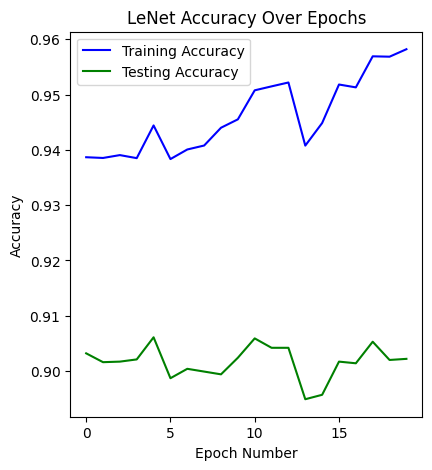

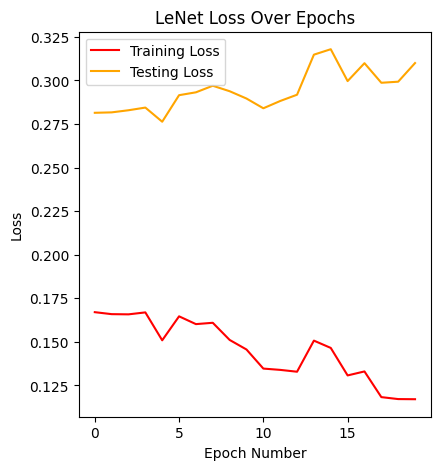

In [ ]:
def plot_graph(data1, data2, label1, label2, title, xlabel, ylabel, color1, color2):
    plt.plot(data1, label=label1, color=color1)
    plt.plot(data2, label=label2, color=color2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

# Plot Training and Testing Accuracy for LeNet
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_graph(
    Convolutional_Neural_Networks_train_accuracy, Convolutional_Neural_Networks_test_accuracy,
    'Training Accuracy', 'Testing Accuracy',
    'LeNet Accuracy Over Epochs',
    'Epoch Number', 'Accuracy',
    'blue', 'green'
)
plt.show()

# Plot Training and Testing Loss for LeNet
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plot_graph(
    Convolutional_Neural_Networks_train_loss, Convolutional_Neural_Networks_test_loss,
    'Training Loss', 'Testing Loss',
    'LeNet Loss Over Epochs',
    'Epoch Number', 'Loss',
    'red', 'orange'
)
plt.show()


# Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?


Our fully connected architecture, encompassing possibly several hidden layers and an output layer with each neuron interconnected across adjacent layers, comprises a total of 506,530 parameters. In contrast, the LeNet5 model possesses a significantly smaller parameter count, featuring convolutional layers that are interconnected and incorporate max-pooling.

Regarding input parameters, the count of parameters within the model is determined by the dimensions of both the input and output layers in each densely connected (fully linked) layer.

As they are linked with each other their weights are shared that helps to minimize count of parameters,

As difference in parameters is displayed in count of parameters.


Overfitting:

In this model accuracy differences is 0.29%, whereas there is big difference in previous model which ranges from 95.82% in train accuracy and test accuracy 90.22%


As we can see in above graph loss is decreasing in both train and test in every epochs which points to model successfully reducing error.

Train and test accuracy are also increasing per epoch which points to model's improvement with new data.


Performance:


Both models perform similarly in terms of test accuracy for the same era. Test accuracy for the Lenet5 is 88.83%, and test accuracy for the fully connected model is 90.22%.


---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


In [ ]:
##############################
# Your code below

class Modernise_LeNet(nn.Module):
    def __init__(self, input_array=(1, 28, 28)):
        super(Modernise_LeNet, self).__init__()
        self.convo_one = nn.Conv2d(input_array[0], 6, kernel_size=5, stride=1, padding=2)
        self.convo_two = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.relu_one = nn.ReLU()
        self.relu_two = nn.ReLU()
        self.maxp_one = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxp_two = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.li_one = nn.Linear(16 * 5 * 5, 280)
        self.li_two = nn.Linear(280, 70)

        self.relu_three = nn.ReLU()
        self.relu_four = nn.ReLU()

        self.li_three = nn.Linear(70, 10)

    def forward(self, x):
        x = self.maxp_one(self.relu_one(self.convo_one(x)))
        x = self.maxp_two(self.relu_two(self.convo_two(x)))
        x = self.flatten(x)
        x = self.relu_three(self.li_one(x))
        x = self.relu_four(self.li_two(x))
        x = self.li_three(x)
        return x


In [ ]:
# Initialise model
modln = Modernise_LeNet()
loss_fn = nn.CrossEntropyLoss()
modlno = torch.optim.Adam(modln.parameters(), lr=1e-3)
modln_train_loss, modln_train_accuracy, modln_test_loss, modln_test_accuracy = train_loop(tr_loader, tt_loader, modln.to(device),loss_fn,modlno,20)

print("Training Accuracy : ", modln_train_accuracy)
print("Test Accuracy : ", modln_test_accuracy)
print("Training Loss : ", modln_train_loss)
print("Test Loss : ", modln_test_loss)

Epoch 1:

loss: 2.300171  [   64/60000]
loss: 0.619247  [ 6464/60000]
loss: 0.573996  [12864/60000]
loss: 0.369922  [19264/60000]
loss: 0.561142  [25664/60000]
loss: 0.486704  [32064/60000]
loss: 0.361104  [38464/60000]
loss: 0.463680  [44864/60000]
loss: 0.345843  [51264/60000]
loss: 0.819463  [57664/60000]
Train Error: 
 Accuracy: 85.9%, Avg loss: 0.377911 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.407590 

Epoch 2:

loss: 0.376403  [   64/60000]
loss: 0.287434  [ 6464/60000]
loss: 0.348112  [12864/60000]
loss: 0.315283  [19264/60000]
loss: 0.341097  [25664/60000]
loss: 0.355152  [32064/60000]
loss: 0.273385  [38464/60000]
loss: 0.601748  [44864/60000]
loss: 0.270039  [51264/60000]
loss: 0.323580  [57664/60000]
Train Error: 
 Accuracy: 89.1%, Avg loss: 0.298951 

Test Error: 
 Accuracy: 87.7%, Avg loss: 0.335386 

Epoch 3:

loss: 0.180117  [   64/60000]
loss: 0.254384  [ 6464/60000]
loss: 0.330293  [12864/60000]
loss: 0.269890  [19264/60000]
loss: 0.483264  [25664/60000]
loss: 0.17

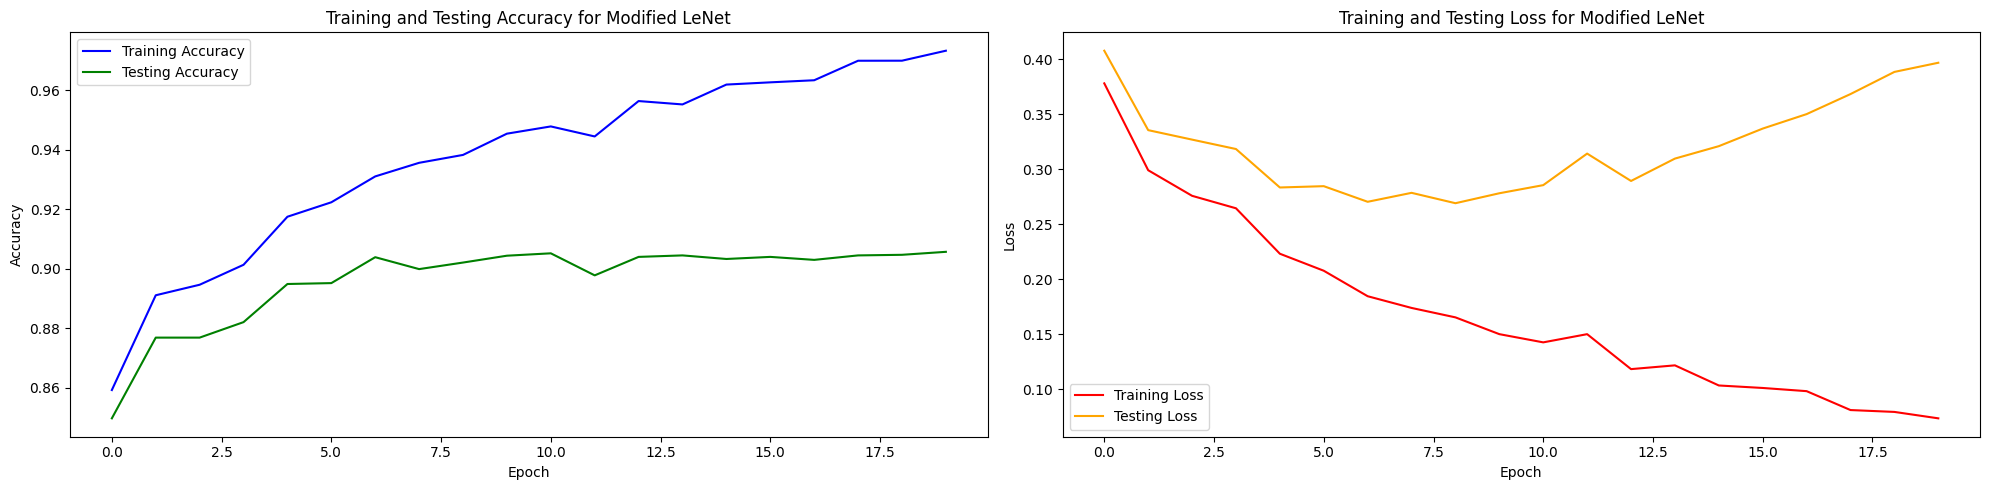

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plotting Accuracy
ax1.plot(modln_train_accuracy, label='Training Accuracy', color='blue')
ax1.plot(modln_test_accuracy, label='Testing Accuracy', color='green')
ax1.set_title('Training and Testing Accuracy for Modified LeNet')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plotting Loss
ax2.plot(modln_train_loss, label='Training Loss', color='red')
ax2.plot(modln_test_loss, label='Testing Loss', color='orange')
ax2.set_title('Training and Testing Loss for Modified LeNet')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

In above class we have used to ReLu activation function and MaxPool2d. With these improvements I am able to reach 97.32% accuracy which is more than LeNet model i.e. 95.82%.


Train accuracy is 90.75% but in LeNet it was 90.02%.
This shows overfitting of model.In loss observation, this model's loss varied from 37% to 7% but in LeNet it was lowered until 11% from 17%. Now since model was overfitting training loss value is greater in Lenet.Now it is noticed that, 90.57% is the accuracy.


---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

In [ ]:
class Custom_Net(nn.Module):
    def __init__(self):
        super(Custom_Net, self).__init__()

        self.conv_one = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv_two = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv_three = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv_four = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv_five = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        self.batch_one = nn.BatchNorm2d(32)
        self.batch_two = nn.BatchNorm2d(64)
        self.batch_three = nn.BatchNorm2d(128)
        self.batch_four = nn.BatchNorm2d(256)
        self.batch_five = nn.BatchNorm2d(512)


        self.relu_one = nn.ReLU()
        self.relu_two = nn.ReLU()
        self.relu_three = nn.ReLU()
        self.relu_four = nn.ReLU()
        self.relu_five = nn.ReLU()

        self.max_one = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max_two = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max_three = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max_four = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max_five = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc_one = nn.Linear(128*7*7, 512)
        self.fc_two = nn.Linear(512, 10)
        self.batch_four = nn.BatchNorm1d(512)
        self.relu_four = nn.ReLU()


    def forward(self, x):
        x = self.max_one(self.relu_one(self.conv_one(x)))
        x = self.relu_two(self.batch_two(self.conv_two(x)))
        x = self.max_three(self.relu_three(self.batch_three(self.conv_three(x))))
        x = self.flatten(x)
        x = self.relu_four(self.batch_four(self.fc_one(x)))
        x = self.fc_two(x)
        return x



 # Initialise model

Cn_model = Custom_Net()
print(Cn_model)

optimizer_Cn = optim.Adam(Cn_model.parameters(), lr=1e-3)

Custom_Net(
  (conv_one): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_two): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_three): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_four): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_five): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_one): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_two): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_three): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_four): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_five): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_one): ReLU()
  (relu_two): ReLU()
  (relu_three): ReLU()
  (relu_four): ReLU()
  (relu_fiv

In [ ]:
Cn_train_loss, Cn_train_accuracy, Cn_test_loss, Cn_test_accuracy = train_loop(tr_loader, tt_loader, Cn_model.to(device),loss_fn,optimizer_Cn,15)

print('Train Accuracy: ', Cn_train_accuracy)
print('Test Accuracy: ', Cn_test_accuracy)
print('Train Loss: ', Cn_train_loss)
print('Test Loss: ', Cn_test_loss)

Epoch 1:

loss: 2.335815  [   64/60000]
loss: 0.342129  [ 6464/60000]
loss: 0.313952  [12864/60000]
loss: 0.240411  [19264/60000]
loss: 0.180568  [25664/60000]
loss: 0.221468  [32064/60000]
loss: 0.308921  [38464/60000]
loss: 0.139711  [44864/60000]
loss: 0.213615  [51264/60000]
loss: 0.130502  [57664/60000]
Train Error: 
 Accuracy: 92.4%, Avg loss: 0.205539 

Test Error: 
 Accuracy: 90.4%, Avg loss: 0.260722 

Epoch 2:

loss: 0.126908  [   64/60000]
loss: 0.183318  [ 6464/60000]
loss: 0.157258  [12864/60000]
loss: 0.187181  [19264/60000]
loss: 0.218947  [25664/60000]
loss: 0.306282  [32064/60000]
loss: 0.087884  [38464/60000]
loss: 0.270199  [44864/60000]
loss: 0.232108  [51264/60000]
loss: 0.276098  [57664/60000]
Train Error: 
 Accuracy: 94.6%, Avg loss: 0.146093 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.221254 

Epoch 3:

loss: 0.153891  [   64/60000]
loss: 0.181371  [ 6464/60000]
loss: 0.186148  [12864/60000]
loss: 0.134903  [19264/60000]
loss: 0.278885  [25664/60000]
loss: 0.15

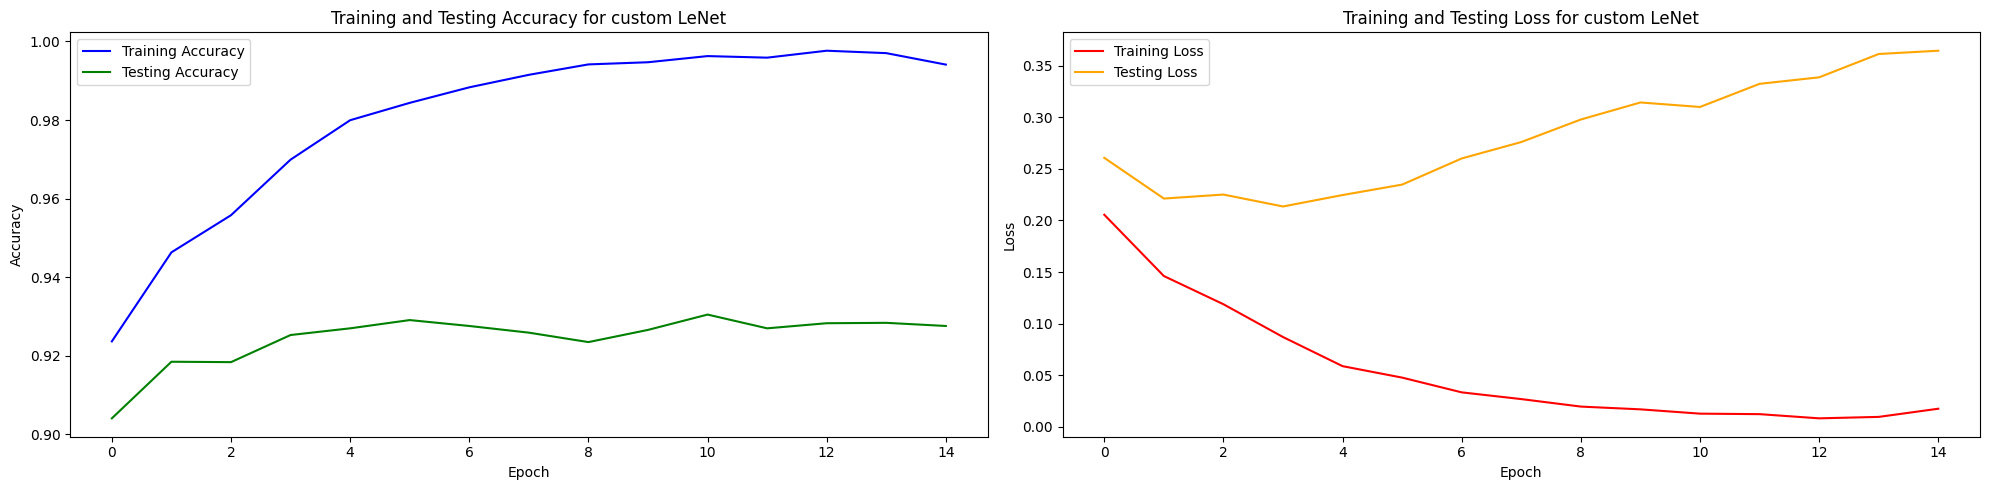

In [ ]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 5))

# Plotting Accuracy
ax3.plot(Cn_train_accuracy, label='Training Accuracy', color='blue')
ax3.plot( Cn_test_accuracy, label='Testing Accuracy', color='green')
ax3.set_title('Training and Testing Accuracy for custom LeNet')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plotting Loss
ax4.plot(Cn_train_loss, label='Training Loss', color='red')
ax4.plot(Cn_test_loss, label='Testing Loss', color='orange')
ax4.set_title('Training and Testing Loss for custom LeNet')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Display the plots
plt.tight_layout()
plt.show()

As advised to boost accuracy BatchNorm2d function is provided. With this batchnorm2d helps to stabilize and expedite training. This model has a test accuracy of 99.41%.




I have added 5 layers 32,64,128,256,512. With these convolution layers capture characteristics which are high in increasing in complexity.

ReLU activation increases convergence during training and assists in the network's understanding of complicated linkages in the data. It also provides the model non-linearity.

This design avoids unnecessary depth that might induce overfitting by establishing a balance between efficiency and complexity.

Convolutional layers enable the network to understand spatial hierarchies, which increases its appropriateness for image-based applications.

Additionally, I omitted the pooling layer from a piece of the convolution layer, which decreases the computational strain. By bypassing certain tiers pooling, the network is able to keep those layers receptive fields smaller and collect more detailed, localized input.



---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [3]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

100%|██████████| 26421880/26421880 [00:02<00:00, 11665787.20it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210520.84it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3909127.28it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20741860.70it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
##############################
# Your code below

res1 = torchvision.models.resnet18(weights=None)
res1.fc = nn.Linear(res1.fc.in_features, 10)

In [7]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res1.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

##############################
# Your code below
res1_train_loss, res1_train_accuracy, res1_test_loss, res1_test_accuracy = train_loop(train_dataloader,test_dataloader,res1.to(device),loss_fn,optimizer,10)

print('Train Accuracy: ', res1_train_accuracy)
print('Test Accuracy: ', res1_test_accuracy)
print('Train Loss: ', res1_train_loss)
print('Test Loss: ', res1_test_loss)

Epoch 1:

loss: 2.535340  [   64/60000]
loss: 0.550677  [ 6464/60000]
loss: 0.335213  [12864/60000]
loss: 0.522791  [19264/60000]
loss: 0.600892  [25664/60000]
loss: 0.410357  [32064/60000]
loss: 0.344323  [38464/60000]
loss: 0.492456  [44864/60000]
loss: 0.273021  [51264/60000]
loss: 0.326261  [57664/60000]
Train Error: 
 Accuracy: 83.0%, Avg loss: 0.423526 

Test Error: 
 Accuracy: 81.3%, Avg loss: 0.463141 

Epoch 2:

loss: 0.238528  [   64/60000]
loss: 0.290542  [ 6464/60000]
loss: 0.255140  [12864/60000]
loss: 0.259035  [19264/60000]
loss: 0.415513  [25664/60000]
loss: 0.392935  [32064/60000]
loss: 0.238905  [38464/60000]
loss: 0.356145  [44864/60000]
loss: 0.251471  [51264/60000]
loss: 0.286380  [57664/60000]
Train Error: 
 Accuracy: 87.3%, Avg loss: 0.326710 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.378684 

Epoch 3:

loss: 0.187590  [   64/60000]
loss: 0.239057  [ 6464/60000]
loss: 0.215773  [12864/60000]
loss: 0.231125  [19264/60000]
loss: 0.275236  [25664/60000]
loss: 0.38

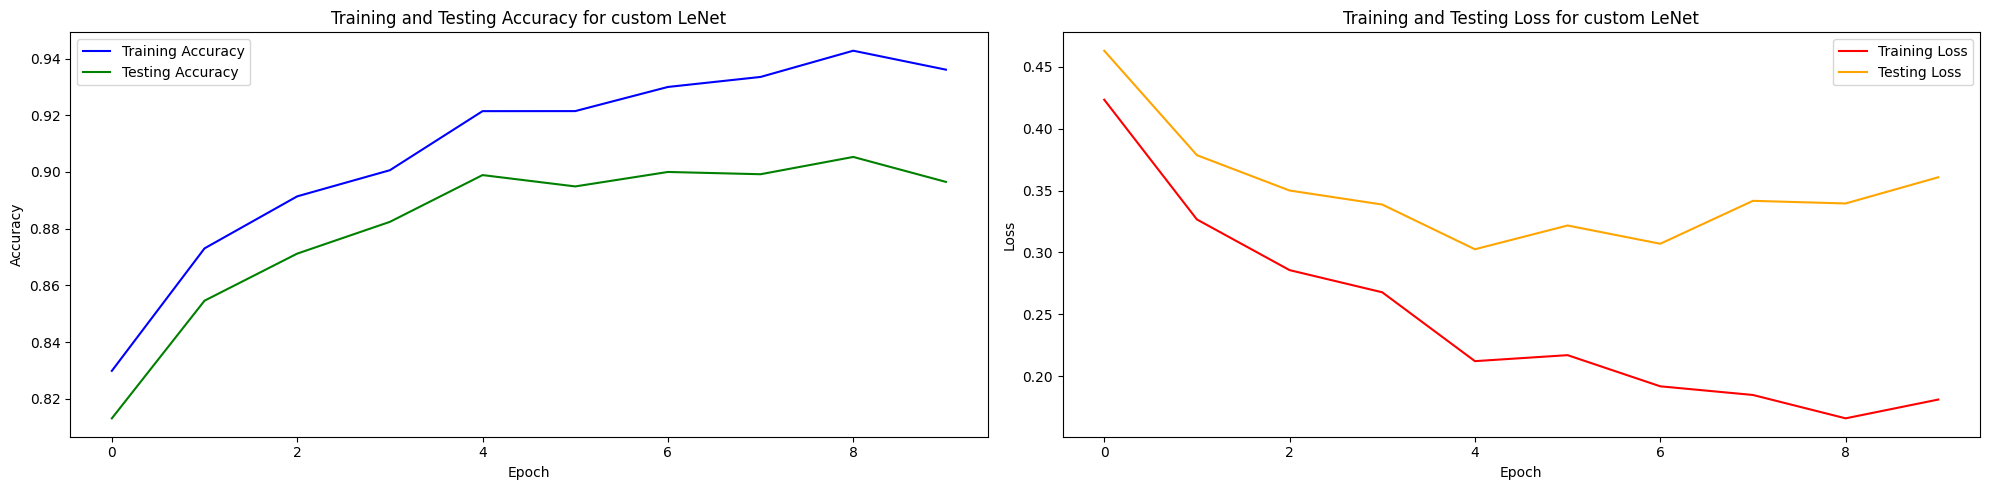

In [8]:
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(20, 5))

# Plotting Accuracy
ax5.plot(res1_train_accuracy, label='Training Accuracy', color='blue')
ax5.plot( res1_test_accuracy, label='Testing Accuracy', color='green')
ax5.set_title('Training and Testing Accuracy for custom LeNet')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Accuracy')
ax5.legend()

# Plotting Loss
ax6.plot(res1_train_loss, label='Training Loss', color='red')
ax6.plot(res1_test_loss, label='Testing Loss', color='orange')
ax6.set_title('Training and Testing Loss for custom LeNet')
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Loss')
ax6.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [9]:
res_def2 = torchvision.models.resnet18(weights='DEFAULT')
res_def2.fc = nn.Linear(res_def2.fc.in_features, 10)
optimizer_def = torch.optim.Adam(res_def2.parameters(), lr=1e-3)
##############################
# Your code below
res_def2_train_loss, res_def2_train_accuracy, res_def2_test_loss, res_def2_test_accuracy = train_loop(train_dataloader,test_dataloader,res_def2.to(device),loss_fn, optimizer_def,10)

print('Train Accuracy: ', res_def2_train_accuracy)
print('Test Accuracy: ', res_def2_test_accuracy)
print('Train Loss: ', res_def2_train_loss)
print('Test Loss: ', res_def2_test_loss)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


Epoch 1:

loss: 2.470343  [   64/60000]
loss: 0.457922  [ 6464/60000]
loss: 0.378146  [12864/60000]
loss: 0.383796  [19264/60000]
loss: 0.483549  [25664/60000]
loss: 0.377989  [32064/60000]
loss: 0.275112  [38464/60000]
loss: 0.442106  [44864/60000]
loss: 0.242517  [51264/60000]
loss: 0.353665  [57664/60000]
Train Error: 
 Accuracy: 87.9%, Avg loss: 0.320374 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.355079 

Epoch 2:

loss: 0.343971  [   64/60000]
loss: 0.334405  [ 6464/60000]
loss: 0.274409  [12864/60000]
loss: 0.282619  [19264/60000]
loss: 0.325025  [25664/60000]
loss: 0.406650  [32064/60000]
loss: 0.222971  [38464/60000]
loss: 0.311042  [44864/60000]
loss: 0.321882  [51264/60000]
loss: 0.236077  [57664/60000]
Train Error: 
 Accuracy: 90.7%, Avg loss: 0.255231 

Test Error: 
 Accuracy: 89.1%, Avg loss: 0.307073 

Epoch 3:

loss: 0.204323  [   64/60000]
loss: 0.270565  [ 6464/60000]
loss: 0.238415  [12864/60000]
loss: 0.185207  [19264/60000]
loss: 0.273797  [25664/60000]
loss: 0.35

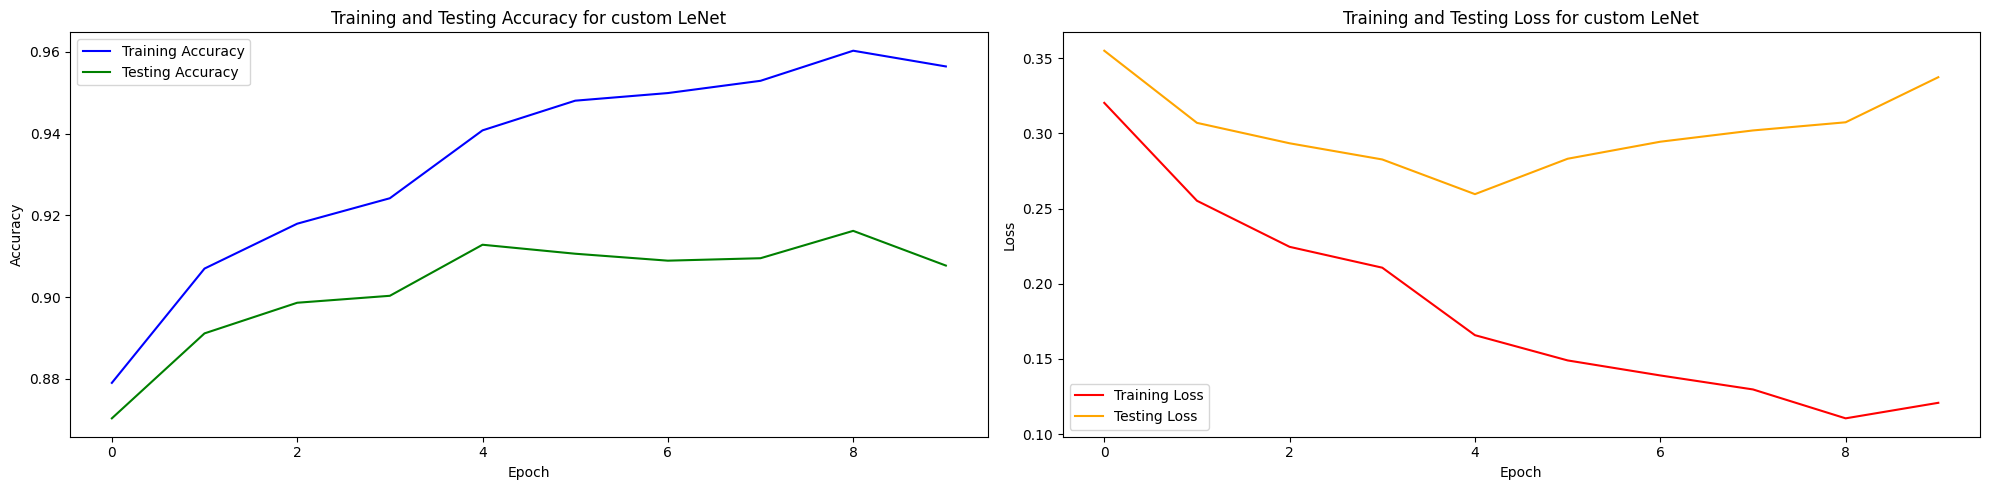

In [10]:
fig, (ax7, ax8) = plt.subplots(1, 2, figsize=(20, 5))

# Plotting Accuracy
ax7.plot(res_def2_train_accuracy, label='Training Accuracy', color='blue')
ax7.plot( res_def2_test_accuracy, label='Testing Accuracy', color='green')
ax7.set_title('Training and Testing Accuracy for custom LeNet')
ax7.set_xlabel('Epoch')
ax7.set_ylabel('Accuracy')
ax7.legend()

# Plotting Loss
ax8.plot(res_def2_train_loss, label='Training Loss', color='red')
ax8.plot(res_def2_test_loss, label='Testing Loss', color='orange')
ax8.set_title('Training and Testing Loss for custom LeNet')
ax8.set_xlabel('Epoch')
ax8.set_ylabel('Loss')
ax8.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [11]:
##############################
# Your code below

res_freeze =  torchvision.models.resnet18(pretrained=True)
replace_last = res_freeze.fc.in_features
res_freeze.fc = nn.Linear(replace_last, 10)

[setattr(param, 'requires_grad', False) for param in res_freeze.parameters()]
[setattr(param, 'requires_grad', True) for param in res_freeze.fc.parameters()]

optimizer = torch.optim.Adam(res_freeze.parameters(), lr=1e-3)

rf_train_loss_frozen, rf_train_accuracy_frozen, rf_test_loss_frozen, rf_accuracy_frozen = train_loop(train_dataloader, test_dataloader, res_freeze.to(device), loss_fn, optimizer, 10)

print('Train Accuracy: ', rf_train_accuracy_frozen)
print('Test Accuracy: ', rf_accuracy_frozen)
print('Train Loss: ', rf_train_loss_frozen)
print('Test Loss: ', rf_test_loss_frozen)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1:

loss: 2.649855  [   64/60000]
loss: 1.264191  [ 6464/60000]
loss: 0.930008  [12864/60000]
loss: 0.986800  [19264/60000]
loss: 0.996560  [25664/60000]
loss: 0.930679  [32064/60000]
loss: 0.867710  [38464/60000]
loss: 0.816147  [44864/60000]
loss: 1.148326  [51264/60000]
loss: 0.960084  [57664/60000]
Train Error: 
 Accuracy: 71.9%, Avg loss: 0.831697 

Test Error: 
 Accuracy: 70.7%, Avg loss: 0.862763 

Epoch 2:

loss: 0.859539  [   64/60000]
loss: 0.860217  [ 6464/60000]
loss: 0.789090  [12864/60000]
loss: 0.801185  [19264/60000]
loss: 0.842713  [25664/60000]
loss: 0.868218  [32064/60000]
loss: 0.804555  [38464/60000]
loss: 0.791001  [44864/60000]
loss: 1.104592  [51264/60000]
loss: 0.900425  [57664/60000]
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.789472 

Test Error: 
 Accuracy: 71.6%, Avg loss: 0.830946 

Epoch 3:

loss: 0.842707  [   64/60000]
loss: 0.795625  [ 6464/60000]
loss: 0.770748  [12864/60000]
loss: 0.772491  [19264/60000]
loss: 0.796510  [25664/60000]
loss: 0.84

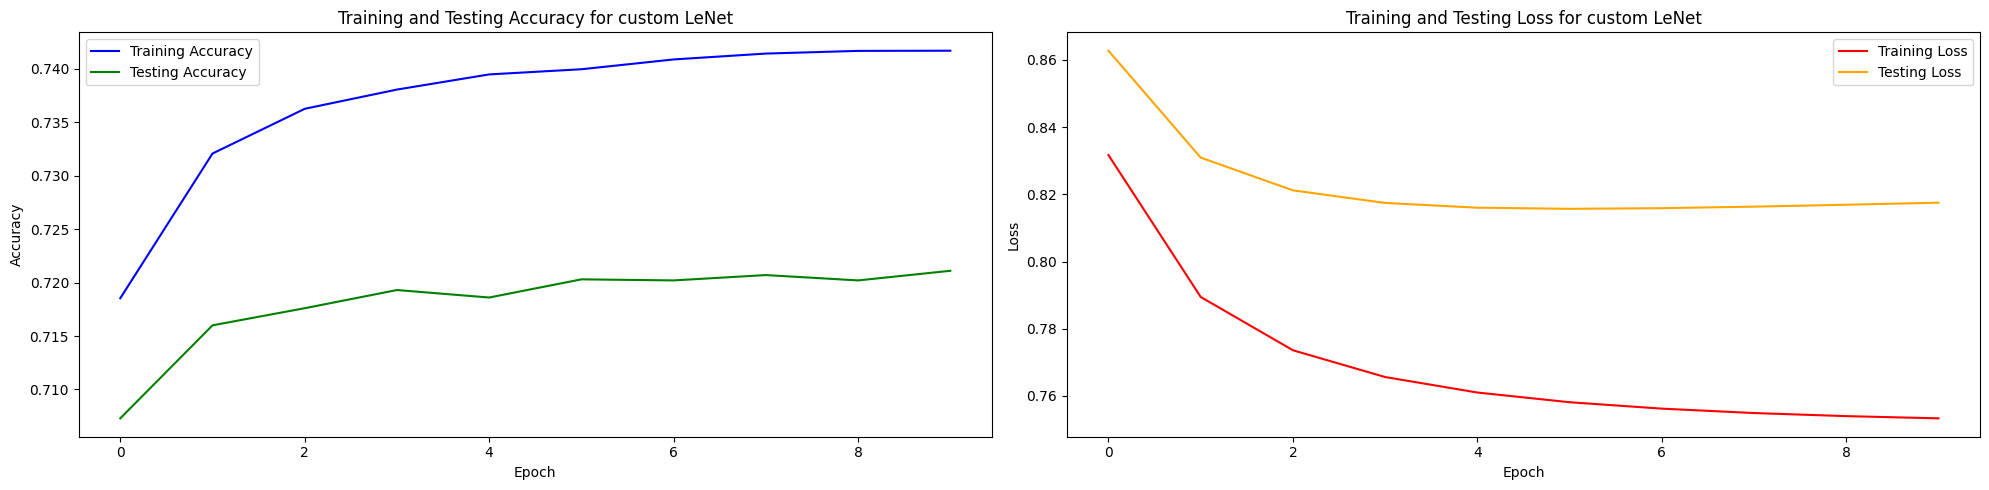

In [12]:
fig, (ax9, ax10) = plt.subplots(1, 2, figsize=(20, 5))

# Plotting Accuracy
ax9.plot(rf_train_accuracy_frozen, label='Training Accuracy', color='blue')
ax9.plot( rf_accuracy_frozen, label='Testing Accuracy', color='green')
ax9.set_title('Training and Testing Accuracy for custom LeNet')
ax9.set_xlabel('Epoch')
ax9.set_ylabel('Accuracy')
ax9.legend()

# Plotting Loss
ax10.plot(rf_train_loss_frozen, label='Training Loss', color='red')
ax10.plot(rf_test_loss_frozen, label='Testing Loss', color='orange')
ax10.set_title('Training and Testing Loss for custom LeNet')
ax10.set_xlabel('Epoch')
ax10.set_ylabel('Loss')
ax10.legend()

# Display the plots
plt.tight_layout()
plt.show()

# 1. Weight = None :-

**Training Accuracy:** - Started at 82.99% and showed a constant rise over time.
- It peaked at 94.28% in the 9th epoch.
- Slightly dropped to 93.61% in the 10th period.

**Testing Accuracy:**
- Began at 81.31% and typically followed an upward trend.
- Reached its maximum at 90.53% in the 9th epoch.
- Dropped a little to 89.65% in the 10th period.

**Training Loss:** - The training loss began at 0.4235 and gradually declined, demonstrating higher model performance.
- The lowest training loss was found in the 9th epoch (0.1659).
- A modest increase in training loss was noted in the 10th epoch (0.1811).

**Testing Loss:** - The testing loss started at 0.4631 and reduced generally, with occasional swings.
- The lowest testing loss was 0.3026 in the 5th epoch.
- There was a considerable rise in the testing loss in the later epochs, reaching 0.3608 in the 10th epoch.

**Overall Observation:** - The model displays progress in both accuracy and loss throughout the epochs. The best performance was around the 9th epoch for both accuracy and loss. The minor decline in accuracy and rise in loss in the 10th epoch might signal the onset of overfitting or some instability in the learning process as the epochs continued.



# 2. Weight = Default :-

**Training Accuracy:** - The training accuracy began at roughly 87.90% and typically improved with time.
- The greatest reported training accuracy was 96.03% during the 9th epoch.
- The ultimate training accuracy was marginally lower at 95.65% in the 10th period.

**Testing Accuracy:** - The testing accuracy started at 87.03% and showed an improving trend.
- It peaked at 91.62% in the 9th epoch.
- There was a minor decline to 90.77% in the 10th epoch.

**Training Loss:** - The training loss began at 0.3204 and generally declined, suggesting better model performance.
- The lowest training loss was 0.1104 in the 9th epoch.
- However, there was a modest rise in training loss to 0.1208 in the 10th epoch.

**Testing Loss:** - The testing loss started at 0.3551 and varied over the epochs.
- It dropped to its lowest at 0.2596 in the 5th epoch.
- The testing loss grew again, reaching 0.3375 at the 10th epoch.

**Overall Observation:** - The model displays a general trend of increase in both accuracy and loss, with the highest performance around the 9th epoch. However, there are modest variations, notably in testing metrics, which might imply overfitting or instability in the model's learning process towards the latter epochs.


# 3. Weight = Freeze Layer

**Training Accuracy:** - Started at 71.85% and showed a progressive rise over time. - The gain in accuracy was rather slight, advancing to 74.17% by the 10th epoch.

**Testing Accuracy:** - Began at 70.73% and similarly exhibited a modest increasing trend. - The highest documented testing accuracy was 72.11% in the 10th epoch.

**Training Loss:** - The training loss began at 0.8317 and subsequently dropped, showing better model performance.
- By the 10th epoch, the training loss was decreased to 0.7533.

**Testing Loss:** - The testing loss started at 0.8628 and, like training loss, exhibited a decline across the epochs.
- The drop was slight, with the loss reaching 0.8175 in the 10th epoch.

**Overall Observation:** - The model demonstrates a consistent but moderate increase in both accuracy and loss. The increases in accuracy and loss throughout the epochs are minimal, demonstrating that the learning is advancing albeit at a moderate pace. The close closeness of training and testing measurements shows that the model is not overfitting much but may benefit from additional tuning or more advanced modeling to boost its learning ability.
